In [17]:
## OVERVIEW

### Business Understanding

Water Problems in Tanzania, like many countries in Sub-Saharan Africa, faces significant challenges related to water supply and quality. The country struggles with uneven distribution and inadequate infrastructure. Many rural areas, in particular, experience severe water scarcity, which impacts health, agriculture, and economic development. The main issues include limited access to safe drinking water, inadequate sanitation, and frequent droughts, which exacerbate water shortages and affect food security. According to reports, only about 57% of the population has access to basic water services, and the situation is even more dire in rural regions where women and children often have to travel long distances to fetch water from unprotected sources, which are often contaminated and unsafe.

Water Well Projects in Tanzania
To address these critical issues, numerous water well projects have been initiated by the Tanzanian government, non-governmental organizations (NGOs), and international aid agencies. These projects aim to provide sustainable access to clean and safe water, primarily in underserved rural areas. The construction of water wells, including boreholes and shallow wells, is a common solution. These wells tap into underground aquifers to provide a reliable source of clean water. Many projects also incorporate the installation of hand pumps and mechanized pumps to improve water retrieval efficiency.

The challenges faced after implementing water well projects in Tanzania revolve around maintenance and sustainability, water quality, community involvement, financial constraints, environmental factors, and coordination with broader water management efforts. These projects encounter issues like the lack of expertise for maintenance, water contamination risks, insufficient community engagement, funding uncertainties, environmental impacts on water availability, and the need for integrated water resource management strategies. Overcoming these challenges demands a comprehensive approach combining technical solutions, community empowerment, sustainable financing, and holistic water management to ensure the long-term success of water well projects in Tanzania.

## Business Problem

We are tasked with developing a prediction tool that will predict water pumps in need of repair. We used the data provided in an iterative modeling process to create a final classification model or tool that can be used by development organizations to predict whether or not a pump is in need of repair before the pump fails. This tool will enable development organizations to appropriately allocate resources in dispatching repair teams.

Being a data science consulting company we have been hired by the Tanzanian Ministry of Water to create a prediction model to help classify whether water pumps are in need of repair (functional, functional but in need of repairs or non-functional). We have been hired to help reduce the possibility of the above mentioned challenges from occuring as it leads to waste of the Ministry's resources and only send out repair teams to pumps that only need of repairs or are non-functional.

 Main object is to maximize accuracy and  recall to ensure the people of Tanzania have access to potable water and few pumps that are non-functional or in need of repairs are over looked.

In [18]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as SNS
import os
%matplotlib inline

from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, \
                            plot_confusion_matrix, plot_roc_curve, roc_auc_score, classification_report, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier

import xgboost
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline


#from yellowbrick.classifier import ROCAUC
#from yellowbrick.style.palettes import PALETTES, SEQUENCES, color_palette

In [19]:
class DataSourcing:
  
  def __init__(self, filepath_status, filepath_features):
        self.filepath_status = filepath_status
        self.filepath_features = filepath_features
        self.load_data()
        self.merge_data()

  def load_data(self):
        self.status_df = pd.read_csv(self.filepath_status)
        self.features_df = pd.read_csv(self.filepath_features)
        print("Data loaded successfully.")
        return self.status_df, self.features_df

  def merge_data(self, how='right', on=None):
        self.data = pd.merge(self.status_df, self.features_df, how=how, on=on)
        print("Data merged successfully.")
        return self.data
  #def __init__(self,dataframe):
    #self.original = dataframe
    #self.dataframe = dataframe
  
  def give_info(self):
    message =  f"""
    ----------------------------------------------------------------------->
    DESCRIPTION OF THE DATAFRAME IN QUESTION:
    ----------------------------------------------------------------------->
    
    Dataframe information => {self.data.info()}
    
    ------------------------------------------------------------------------------------------------------------------------->
    
    Dataframe shape => {self.data.shape[0]} rows, {self.data.shape[1]} columns
    ------------------------------------------------------------------------------------------------------------------------->    
    
    There are {len(self.data.columns)} columns, namely: {self.data.columns}.  
    ------------------------------------------------------------------------------------------------------------------------->
        
    The first 5 records in the dataframe are seen here:
    ------------------------------------------------------------------------------------------------------------------------->
    {self.data.head()}

    ------------------------------------------------------------------------------------------------------------------------->
        
    The number of occurrences of each unique value in every column are seen here:
    ------------------------------------------------------------------------------------------------------------------------->
    {self.data.value_counts()}
    ------------------------------------------------------------------------------------------------------------------------->
       
    The last 5 records in the self.dataframe are as follows: 
    ------------------------------------------------------------------------------------------------------------------------->
    {self.data.tail()}
    ------------------------------------------------------------------------------------------------------------------------->
    
    The descriptive statistics of the dataframe (mean,median, max, min, std) are as follows:
    ------------------------------------------------------------------------------------------------------------------------->
    {self.data.describe()}
    ------------------------------------------------------------------------------------------------------------------------->
    """
    print (message)
  
  def null_count(self):
    return self.data.isnull().sum()
  
  def unique_count(self):
    return self.data.nunique()
  
  def unique_per_column(self):
      print("<----- UNIQUE VALUES IN EACH COLUMN ----->")
      for col in self.data.columns:
              unique_values = self.data[col].unique()
              str_values = [x for x in unique_values if isinstance(x, str)]
              num_values = [x for x in unique_values if isinstance(x, (int, float))]
              other_values = [x for x in unique_values if not isinstance(x, (int, float, str))]
              
              sorted_str_values = sorted(str_values)
              sorted_num_values = sorted(num_values)
              
              print(f"{col} ({len(unique_values)} unique)")
              if sorted_str_values:
                  print(f"String values:\n {sorted_str_values}")
              if sorted_num_values:
                  print(f"Numeric values:\n {sorted_num_values}")
              if other_values:
                  print(f"Other values:\n {other_values}")
              print()
        
      print("<----- END OF UNIQUE VALUES IN EACH COLUMN ----->")
      return

    



In [20]:
class DataPreProcessing():
    def __init__(self, data):
        self.data = data
        self.replace_zero_value()
        self.replace_nulls_with_unknown()
        self.create_water_per_person_feature()
        self.group_and_count('scheme_management', 'status_group')
        self.convert_to_datetime('date_recorded')
        self.calculate_age_at_inspection()
        self.create_unknown_construction_year_feature()
        self.rename_other_school_to_school()
        self.bin_urban_groups('lga')
        self.drop_columns()
    

    def replace_zero_value(self):
        """Replace 0 population values with mean in the population column."""
        self.data['population'].replace(to_replace=0, value=self.data['population'].mean(), inplace=True)
        self.data['construction_year'].replace(to_replace=0, value=np.nan, inplace=True)
        return self.data.replace()

    def replace_nulls_with_unknown(self, column):
        """Replace null values with 'Unknown' in specified columns."""
        for col in columns:
            self.data['public_meeting', 'permit', 'funder', 'installer', 'scheme_management'].replace(to_replace=np.nan, value="Unknown", inplace=True)
        

    def create_water_per_person_feature(self):
        """Create a new 'water_per_person' feature using the population column."""
        self.data['water_per_person'] = self.data['amount_tsh'] / self.data['population']
        
   
    def group_and_count(self, group_by_column, count_column, normalize=False):
        if group_by_column in self.data.columns and count_column in self.data.columns:
            return self.data[group_by_column].groupby(self.data[count_column]).value_counts(normalize=normalize)
        else:
            missing_columns = [col for col in [group_by_column, count_column] if col not in self.data.columns]
            print(f"Columns not found in the DataFrame: {', '.join(missing_columns)}")

    def convert_to_datetime(self, column):
        """Convert date_recorded column to datetime"""
        self.data['date_recorded'] = pd.to_datetime(self.data['date_recorded'])

    
    def calculate_age_at_inspection(self):
        """Calculate the age at inspection based on construction year using the date_recorded column 
        which will be later dropped as we create 'age_at_inspection column'."""
        if 'date_recorded' in self.data.columns:
            print(self.data['date_recorded'].dtype)
            if pd.api.types.is_datetime64_any_dtype(self.data['date_recorded']):
                self.data['age_at_inspection'] = self.data['date_recorded'].dt.year - self.data['construction_year']
            else:
                print("Column 'date_recorded' is not in datetime format.")
        else:
            print("Column 'date_recorded' not found in the DataFrame.")


    def create_unknown_construction_year_feature(self):
        self.data['age'] = self.data['construction_year'] == 0
       
        
    def rename_other_school_to_school(self):
        """Rename 'other - school' category to 'school' in the management column."""
        self.data['management'] = self.data['management'].replace("other - school", "school")

    def bin_urban_groups(self, column):
        """
        Bin together specified urban groups in a DataFrame column."""
        urban_groups = [
        "Moshi Urban", "Kigoma Urban", "Arusha Urban", 
        "Lindi Urban", "Bukoba Urban", "Songea Urban", 
        "Morogoro Urban", "Mtwara Urban"
        ]
        self.data['lga'] = self.data['lga'].replace(urban_groups, "Urban")
        

    def drop_columns(self):
        """Drop specified columns from the dataframe."""
        self.data.drop(columns= ['date_recorded', 'longitude', 'quality_group', 'wpt_name', 'extraction_type', 'extraction_type_group', 'management_group','latitude', 'id', 'population', 'scheme_name', 'region', 'ward', 'lga', 'payment_type'] , inplace=True)
        


#### Loading the dataset

In [21]:
# Filepaths to the datasets
 
filepath_features = ('Data\water_columns.csv')
filepath_status = ('Data/water_status_group.csv')


## Data Understanding

In [22]:
#Initializing the DataSourcing class

data_source = DataSourcing(filepath_status, filepath_features)
  
data_source.give_info()

Data loaded successfully.
Data merged successfully.
<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   status_group           59400 non-null  object 
 2   amount_tsh             59400 non-null  float64
 3   date_recorded          59400 non-null  object 
 4   funder                 55765 non-null  object 
 5   gps_height             59400 non-null  int64  
 6   installer              55745 non-null  object 
 7   longitude              59400 non-null  float64
 8   latitude               59400 non-null  float64
 9   wpt_name               59400 non-null  object 
 10  num_private            59400 non-null  int64  
 11  basin                  59400 non-null  object 
 12  subvillage             59029 non-null  object 
 13  region                 59400 non-null  object 
 14  re

In [23]:
data_source.data['status_group'].value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

In [24]:
data_source.data['num_private'].value_counts()

0      58643
6         81
1         73
5         46
8         46
       ...  
180        1
213        1
23         1
55         1
94         1
Name: num_private, Length: 65, dtype: int64

In [25]:
data_source.data['status_group'].value_counts(normalize = True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

In [26]:
data_source.data.nunique()

id                       59400
status_group                 3
amount_tsh                  98
date_recorded              356
funder                    1897
gps_height                2428
installer                 2145
longitude                57516
latitude                 57517
wpt_name                 37400
num_private                 65
basin                        9
subvillage               19287
region                      21
region_code                 27
district_code               20
lga                        125
ward                      2092
population                1049
public_meeting               2
recorded_by                  1
scheme_management           12
scheme_name               2696
permit                       2
construction_year           55
extraction_type             18
extraction_type_group       13
extraction_type_class        7
management                  12
management_group             5
payment                      7
payment_type                 7
water_qu

In [27]:


data_source.unique_per_column()

<----- UNIQUE VALUES IN EACH COLUMN ----->
id (59400 unique)
Other values:
 [69572, 8776, 34310, 67743, 19728, 9944, 19816, 54551, 53934, 46144, 49056, 50409, 36957, 50495, 53752, 61848, 48451, 58155, 34169, 18274, 48375, 6091, 58500, 37862, 51058, 22308, 55012, 20145, 19685, 69124, 46804, 6696, 57238, 12402, 41583, 57355, 67359, 60048, 16583, 25, 70238, 12796, 52019, 19282, 1843, 12958, 45111, 13620, 18864, 25182, 3228, 19308, 10745, 32376, 9417, 68724, 74197, 22961, 24593, 31714, 29952, 40393, 2127, 8265, 67433, 51072, 34255, 22108, 4720, 54801, 21990, 17386, 41609, 35715, 53970, 62971, 63542, 15622, 12903, 52561, 19415, 65531, 3675, 34383, 30423, 68717, 3688, 30537, 27312, 22143, 43237, 62591, 39920, 70892, 48593, 26419, 68554, 29083, 33379, 43206, 41743, 17970, 25693, 39364, 57580, 23000, 59902, 60371, 74246, 7116, 64063, 59983, 10784, 49503, 54248, 24409, 21068, 62341, 10837, 35458, 36038, 64447, 22897, 2915, 14016, 69525, 73061, 42031, 33235, 41839, 62002, 6106, 25915, 20673, 594

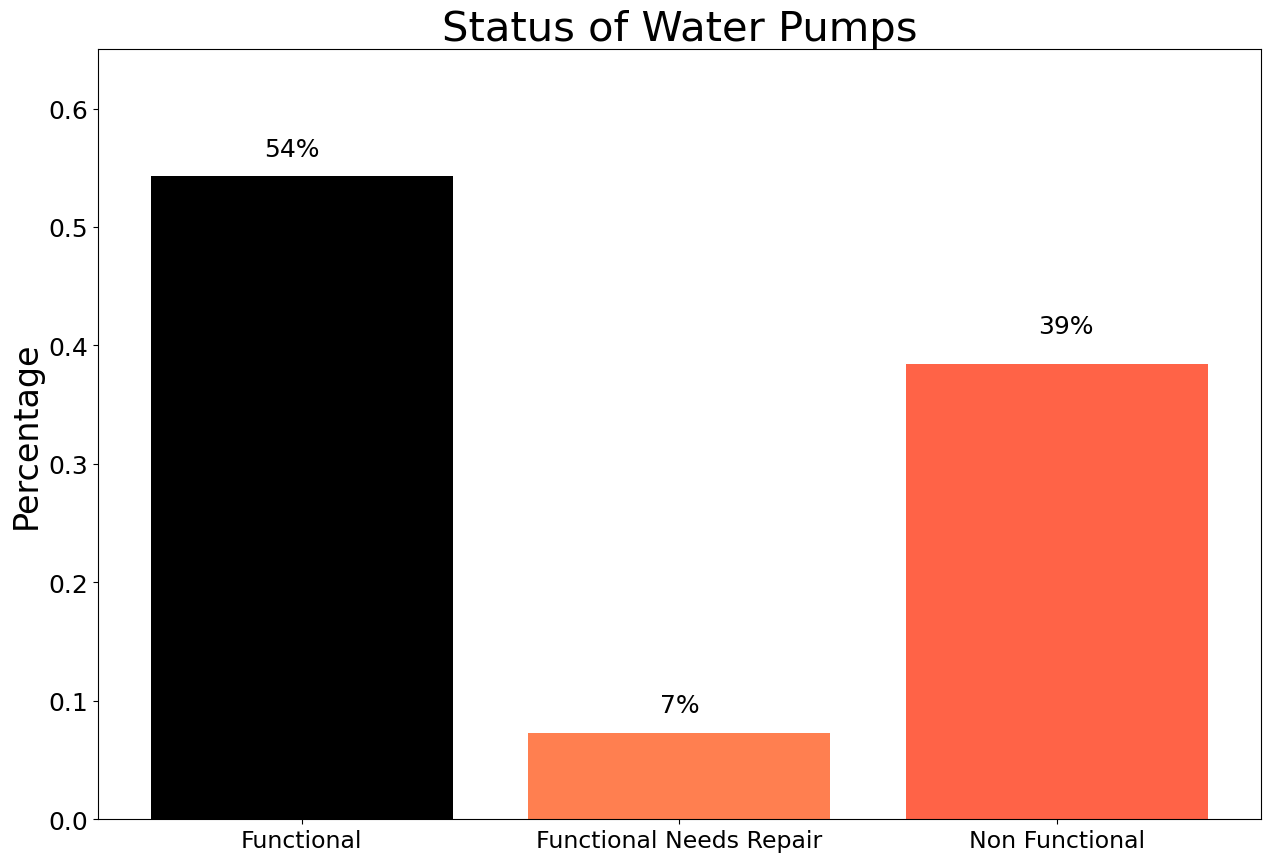

In [28]:
fig, ax = plt.subplots(figsize = (15, 10))

x = ["Functional", "Functional Needs Repair", "Non Functional"]
height = [0.543081, 0.072677, 0.384242]
ax.tick_params(axis="x", labelsize=17)
ax.tick_params(axis="y", labelsize=18)

ax = plt.bar(x=x, 
        height=height, color = ["black", "coral", "tomato"])
plt.title("Status of Water Pumps", fontsize=30)
plt.ylabel("Percentage", fontsize=24);
plt.ylim(0, .65)

plt.text(.95, .09, '7%', 
         fontsize = 18, color = 'k')

plt.text(1.95, .41, '39%', 
         fontsize = 18, color = 'k')
plt.text(-.1, .56, '54%', 
         fontsize = 18, color = 'k');

image_dir = './images'
os.makedirs(image_dir, exist_ok=True)

# Plotting and saving the figure

plt.savefig(os.path.join(image_dir, 'Well_Status_bar_Chart.png'), bbox_inches="tight", dpi=500)


- The focus is on the water_status_group (Target) and water_columns (Features) datasets  that have been merged to create a more comprehensive dataset 'Data' that contains 59400 rows which are the total number pumps and 41 columns. 


- The following is a list of the 41 column names and descriptions:

amount_tsh - Total static head (amount water available to waterpoint)
date_recorded - The date the row was entered
funder - Who funded the well
gps_height - Altitude of the well
installer - Organization that installed the well
longitude - GPS coordinate
latitude - GPS coordinate
wpt_name - Name of the waterpoint if there is one
num_private -
basin - Geographic water basin
subvillage - Geographic location
region - Geographic location
region_code - Geographic location (coded)
district_code - Geographic location (coded)
lga - Geographic location
ward - Geographic location
population - Population around the well
public_meeting - True/False
recorded_by - Group entering this row of data
scheme_management - Who operates the waterpoint
scheme_name - Who operates the waterpoint
permit - If the waterpoint is permitted
construction_year - Year the waterpoint was constructed
extraction_type - The kind of extraction the waterpoint uses
extraction_type_group - The kind of extraction the waterpoint uses
extraction_type_class - The kind of extraction the waterpoint uses
management - How the waterpoint is managed
management_group - How the waterpoint is managed
payment - What the water costs
payment_type - What the water costs
water_quality - The quality of the water
quality_group - The quality of the water
quantity - The quantity of water
quantity_group - The quantity of water
source - The source of the water
source_type - The source of the water
source_class - The source of the water
waterpoint_type - The kind of waterpoint
waterpoint_type_group - The kind of waterpoint  

- Dataframe shape => 59400 rows, 41 columns



In [29]:
data_prep = DataPreProcessing(data=data_source.data)

data_prep.data.head()

TypeError: replace_nulls_with_unknown() missing 1 required positional argument: 'column'

In [32]:
data_prep.data.drop(columns= [ 'num_private', 'subvillage', 'recorded_by', 'quantity_group', 'source_type', 'source_class', 'waterpoint_type_group', 'water_per_person' ] , inplace=True)

data_prep.data.info()

NameError: name 'data_prep' is not defined

- There are unbalanced targets in the status_group values and may need to be addressed in our models and data analysis.
In the 'num_private' colunm, there are 58643 items that are 0 and the assumption is that the data was unavailable. This in turn might affect the 'recorded_by' column, that's why they'll be dropped.

- There are simillar values in the 'Quanity' and 'Quanity_group', 'waterpoint_type' and 'waterpoint_type_group', we'll have to drop 'Quanity_group' and 'waterpoint_type_group'.
- 'Source' and 'Source_type' have same values and 'Source_class' column values categorize the former two columns into ground water and surface which doesn;t have much of a difference. 'Source_type' and 'Source_class' will be dropped.

- 'public_meeting', 'permit', 'funder', 'installer' columns have null values which might been values that were ommitted because the total number of null values for each column is approximately 5%. The values will be replaced with unknown.

- We drop 'scheme name' since 'scheme management' captures similar data more cleanly with fewer nulls. Since Nulls is our 3rd highest category, we want to capture that information and will replace our Nulls with "Unknown."

- we see 34% of our data is missing the year construction

- 'wpt_name' is dropped because it has 'none' has it's mode